**Importing Libraries and Setting Up Figure Style**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import ML
import lightgbm as lgb #gradient boosted decsion tree machine
from sklearn.model_selection import KFold, RandomizedSearchCV #cross validation
from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

# set up plot styles
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("talk")


Above we have imported all the modules needed for reading and cleaning the database, data viz and machine learning analysis of the data. We have chosen to use a light gradient boosted machine (lightgbm) to build our model as it has been shown to return models with low mean square error compared to decsion tree, random forest, SVM, kNN.We also set the appreance of plots at this step so our output has a consistent style. This is an important (and often overlooked!) point for convinvcing reports for stakeholders of both technical and non-technical backgrounds.


**Read Data Files into Dataframe**

In [2]:

calendar_df = pd.read_csv('./DS/calendar.csv',parse_dates=['date'])
listings_df = pd.read_csv('./DS/listings.csv')
#reviews_df = pd.read_csv('./DS/reviews.csv') #not useful w/o NLP-sentiment analysis

calendar_df.head()


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Firstly, we should determine how many missing entries/NAN in each of the columns. We also need to clean the data by converting 'available' column entries to logic 0 or 1 instead of 'f' and 't' and then stripping dollar signs and commas from 'price' and force it as a float. 

In [3]:
calendar_df['available'] = calendar_df['available'].map({'f':0,'t':1})
calendar_df['price'] = calendar_df['price'].replace({'\$':'',',':''}, regex = True).astype(float)


calendar_cols_NaN_df = 100*calendar_df.isnull().mean() #NaN % per column

for col in calendar_df:
    if calendar_df[col].isnull().any():
        print('\n  %s column is %0.2f percent "NaN" \n' %(col,calendar_cols_NaN_df[col]))

Available_Price_NaN_df = calendar_df[calendar_df['available']>0]
Available_Price_NaN_mean = Available_Price_NaN_df['price'].isnull().mean()
#booking_mean = calendar_df['available'].mean()          
print('  of which %0.2f percent are available \n' %Available_Price_NaN_mean)
        
calendar_df.head()


  price column is 32.94 percent "NaN" 

  of which 0.00 percent are available 



,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


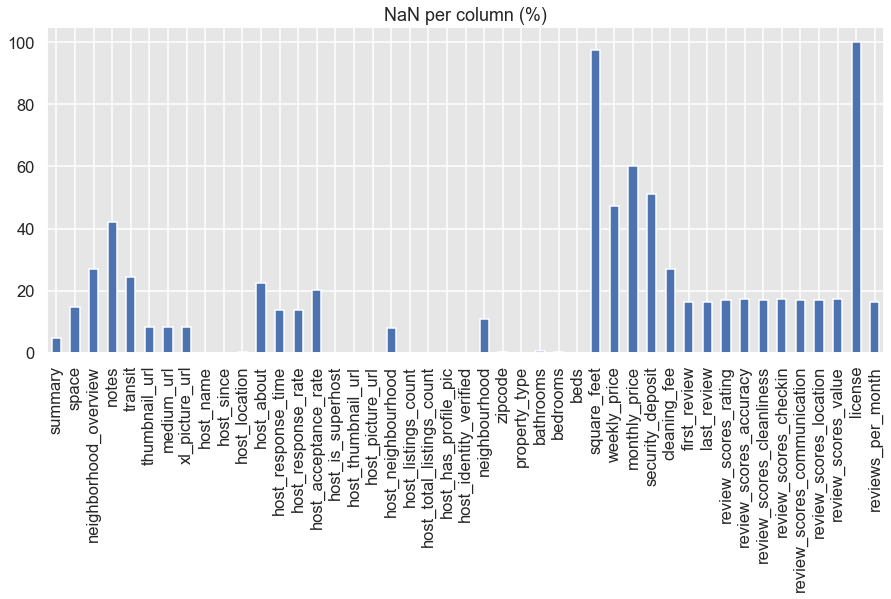

In [4]:
listings_cols_NaN_df = 100*listings_df.isnull().mean()
        
ax1 = listings_cols_NaN_df[listings_cols_NaN_df>0.02].plot.bar(figsize=(15, 6),title='NaN per column (%)') #show columns with >2% NaN entries



Nearly 33% of listings do not list a price (or the scraper failed to find it), but all of these missing values are from listings which are unavailable, and so we do not need to replace the missing data with some method (mean or median price etc). We also see that there several features (columns) in the lisitings database with large amounts (>25%) of missing data, these features will not be useful for traing our machine learning models.

**Exploratory Data Analysis**

Daily price distribution and mean:

Cheapest listing mean price is $20.00 per night
Most Expensive listing mean price is $1301.82 per night
The Average listing mean price is $135.76 per night
The Median listing mean price is $108.42 per night


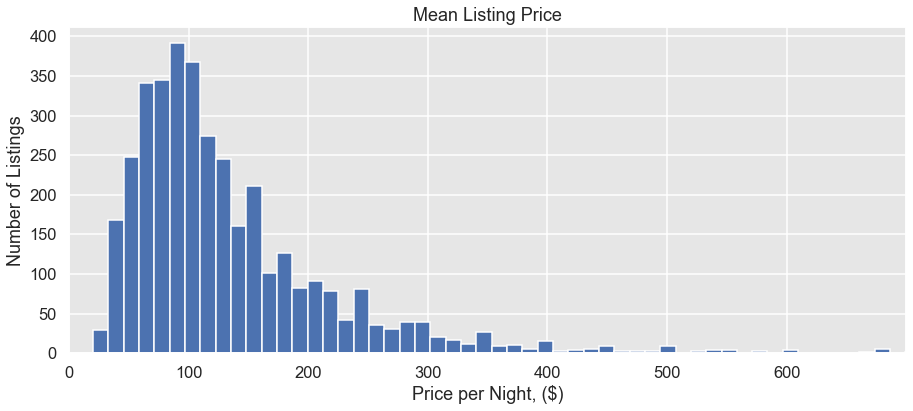

In [5]:
overview_df = calendar_df[calendar_df['available']>0] # unbooked properties with price information 
mean_listing_prices = overview_df.groupby('listing_id')['price'].mean()
print('Cheapest listing mean price is $%0.2f per night' %mean_listing_prices.min())
print('Most Expensive listing mean price is $%0.2f per night' %mean_listing_prices.max())
print('The Average listing mean price is $%0.2f per night' %mean_listing_prices.mean())
print('The Median listing mean price is $%0.2f per night' %mean_listing_prices.median())

#plot mean price distribution
plt.figure(figsize=(15,6))
plt.hist(mean_listing_prices, bins=100)
plt.xticks(np.arange(0, 700, step=100))
plt.xlim((0, 700))
plt.ylabel('Number of Listings')
plt.xlabel('Price per Night, ($)')
plt.title('Mean Listing Price');



**Insights** 

We see that listing prices follow a positive skewed normal distribution with a mean price of \\$135 per night and median price of \\$108 per night. The most expensive listing is \\$1300 a night and the cheapest just \\$20 per night.



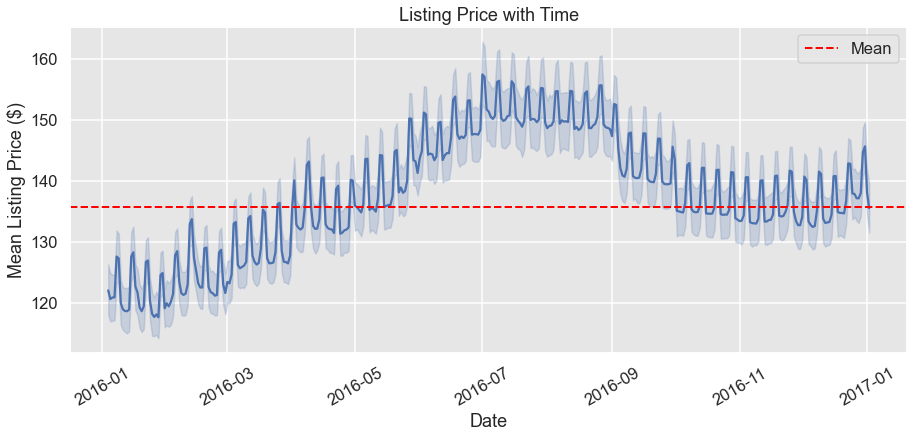

In [6]:
#plot mean price change with time
plt.figure(figsize=(15,6))
ax2 = sns.lineplot(x="date", y="price",markers = True, dashes = False, data = calendar_df[calendar_df['available']>0])
plt.axhline(mean_listing_prices.mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.xticks(rotation = 30)
plt.title('Listing Price with Time')
plt.xlabel('Date')
plt.ylabel('Mean Listing Price ($)')
plt.legend(loc='best');

**Insights:**

Mean prices spike each weekend and rise over the year to over \\$150 a night during the summer period. Potential hosts should ensure their property has good availability over this period to maximize returns. 

Availablity of Listings Analysis:

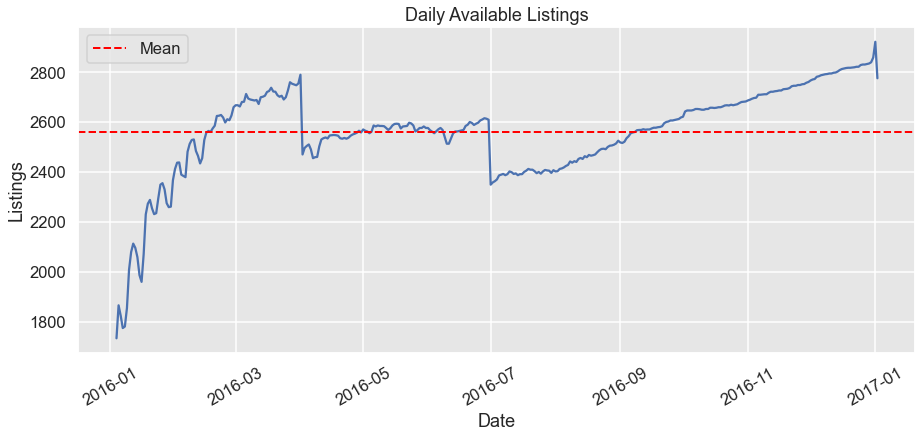

In [7]:
listings_number = calendar_df[calendar_df['available']>0].groupby('date')['listing_id'].nunique()

plt.figure(figsize=(15,6))
plt.plot(listings_number)
plt.axhline(listings_number.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 30)
plt.title('Daily Available Listings')
plt.xlabel('Date')
plt.ylabel('Listings')
plt.legend(loc='best');

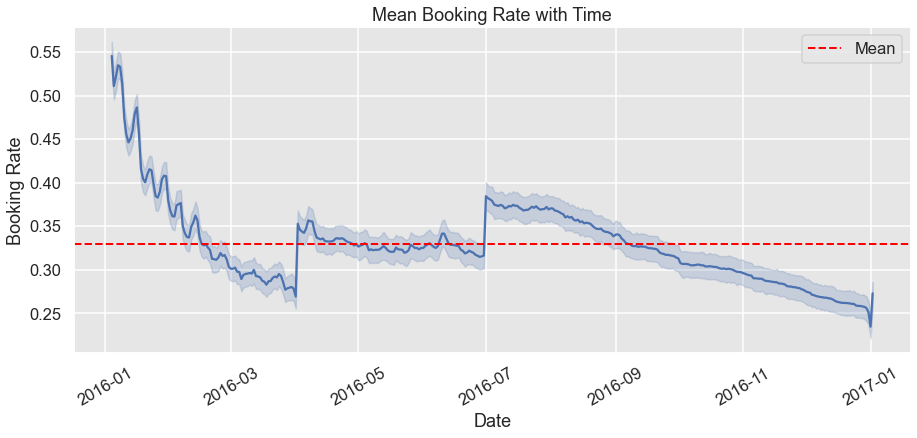

In [8]:
#calculate and plot booking rate

calendar_df['booked'] = abs(calendar_df['available']-1) #if listing is available it is not booked

plt.figure(figsize=(15,6))
ax3 = sns.lineplot(x="date", y="booked",markers = True, dashes = False, data = calendar_df)
plt.axhline(calendar_df['booked'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')

plt.xticks(rotation = 30)
plt.title('Mean Booking Rate with Time')
plt.xlabel('Date')
plt.ylabel('Booking Rate')
plt.legend(loc='best');




**Insights** 

We find the number of listings increases across the year from 1800 to 2800 and as a result supply outstrips demand and the mean booking rate per night slumps from 55\% to 25\% with a average across the year of 34\% of listings booked each night. We also see large jumps in the booking rate around holiday weekends (Easter and Independence Day).


**Exploring Feature Correlations:**

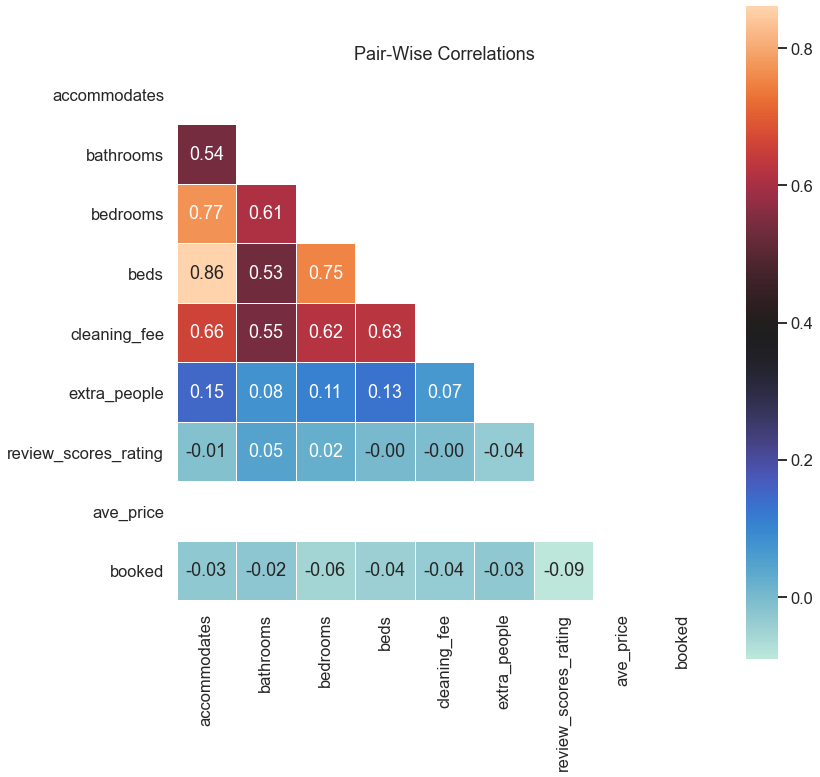

In [83]:
#Feature columns to calculate correlations on
colms = ['accommodates','bathrooms','bedrooms','beds',
        'cleaning_fee', 'extra_people',
        'review_scores_rating', 'ave_price','booked']
#combine average price and booking info with listing info
ave_price = calendar_df[calendar_df['available']>0].groupby('listing_id')['price'].mean()
all_df = pd.merge(listings_df, ave_price, how='left', left_on='id', right_on='listing_id')

all_df[['cleaning_fee','extra_people']] = all_df[['cleaning_fee','extra_people']].replace({'\$':'',',':''}, regex = True).astype(float) #clean up "cleaning_fee" (hehe)

# set up heatmap of pair-wise correlations
corr = all_df[colms].astype(float).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

#plot heatmap of pair-wise correlations
plt.figure(figsize=(12,12))
ax4 = sns.heatmap(corr, mask=mask, linewidths=0.5, square=True, cmap="icefire", linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-Wise Correlations');
ax4.set_facecolor("white")


In [84]:
print(ave_price)
all_df[['id','ave_price']]


listing_id
3335        120.000000
4291         82.000000
5682         53.944984
6606         92.849315
7369         85.000000
               ...    
10331249     45.000000
10332096     40.000000
10334184    120.000000
10339145    237.904110
10340165     43.000000
Name: price, Length: 3723, dtype: float64


,id,ave_price
0,241032,NaN
1,953595,NaN
2,3308979,NaN
3,7421966,NaN
4,278830,NaN
...,...,...
3813,8101950,NaN
3814,8902327,NaN
3815,10267360,NaN
3816,9604740,NaN
